In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from scipy.optimize import brentq

In [43]:
# Define parameters
N = 500
T = 300
M = 50000
dt = 0.01
t0 = 0

pi = np.pi

k = 1
a = 0.1
b = 0.26
c = -65
d = 0 #-1

A = 0.04
B = 5
C = 140

# v_reset = -10/A - B/(2*A)
# v_thresh = 10/A - B/(2*A) 

v_reset = -1000
v_thresh = 1000

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

p_jump = 2.7185823035951033

# Heterogeneity parameters for the intrinsic current eta
Delta = 0.02     # half-width of Lorentzian for eta
etaBar = 0.8     # mean intrinsic current

J = stats.cauchy.rvs(loc=etaBar, scale=Delta, size=N)
I = 0

# All-to-all connected, can use single s and p as all neuron receive same input
g = 0.2

In [44]:
# Network simulation functions
def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N]
    p = x[-1]
    
    dvdt = k * (A*v**2 + B*v + C - u + I) + J - (v - Esyn)*g*s
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, [dsdt], [dpdt]])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

In [45]:
# Define the mean-field ODE system
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g*s)*r + 2.0*A*r*v +  Delta*A/pi
    dvdt = - (pi**2 / A)*(r**2) + A*(v**2) + B*v + C - u + I + etaBar + g*s*(Esyn - v)
    dudt = a*(b*v - u) + d*r
    dsdt = - s / tauS + p / tauS
    dpdt = -(p/tauS) + p_jump*r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# g Bifurcation Analysis

In [46]:
# Physical FP r>0
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, g, tauS):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.09 , -62]  # initial guesses for r, v
g_values = np.linspace(0,1,11)

for g in g_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(g, tauS))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"g = {g:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], g, tauS))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

g = 0.00, Fixed point (r, v, u, s, p): 0.05745566697416363, -62.55540095571827, -16.264404248486752, 0.4753171139246578, 0.4753171139246578
Residuals (should be close to zero):
dr/dt, dv/dt: [3.0601606318403363e-15, 1.2723155862204294e-13]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
g = 0.10, Fixed point (r, v, u, s, p): 0.04211888544577447, -62.140024702914154, -16.15640642275768, 0.34843955568057733, 0.34843955568057733
Residuals (should be close to zero):
dr/dt, dv/dt: [-2.7050844203513336e-16, 4.346523141407488e-14]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
g = 0.20, Fixed point (r, v, u, s, p): 0.031630421429131056, -61.946456648375445, -16.106078728577618, 0.26167097899456726, 0.26167097899456726
Residuals (should be close to zero):
dr/dt, dv/dt: [-3.299433209286162e-14, 2.1396218130576017e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
g = 0.30, Fixed point (r, v, u, s, p): 0.0247275643492251, -61.86160694995757, -16.084017806988967, 0.2045652785850551, 0.2045652785850551
Residuals (should be clo

In [47]:
# Physical FP r<0
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, g, tauS):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [-0.09 , -62]  # initial guesses for r, v
g_values = np.linspace(0,1,11)

for g in g_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(g, tauS))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"g = {g:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], g, tauS))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

g = 0.00, Fixed point (r, v, u, s, p): -0.056421141703151545, -62.44358322489767, -16.235331638473394, -0.46675873157534653, -0.46675873157534653
Residuals (should be close to zero):
dr/dt, dv/dt: [-5.1618323330948623e-14, 8.519851490973451e-13]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
g = 0.10, Fixed point (r, v, u, s, p): -0.07651922964972027, -63.24968313261669, -16.44491761448034, -0.6330254492250211, -0.6330254492250211
Residuals (should be close to zero):
dr/dt, dv/dt: [-2.522356238807144e-13, -1.4941659021161513e-11]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
g = 0.20, Fixed point (r, v, u, s, p): -0.09801935976837868, -64.49475313816373, -16.768635815922572, -0.8108909294325823, -0.8108909294325823
Residuals (should be close to zero):
dr/dt, dv/dt: [-1.4454399049207423e-13, -9.171885473335806e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
g = 0.30, Fixed point (r, v, u, s, p): -0.1172462665596996, -66.11016581494447, -17.18864311188556, -0.9699505718845371, -0.9699505718845371
Residuals (shou

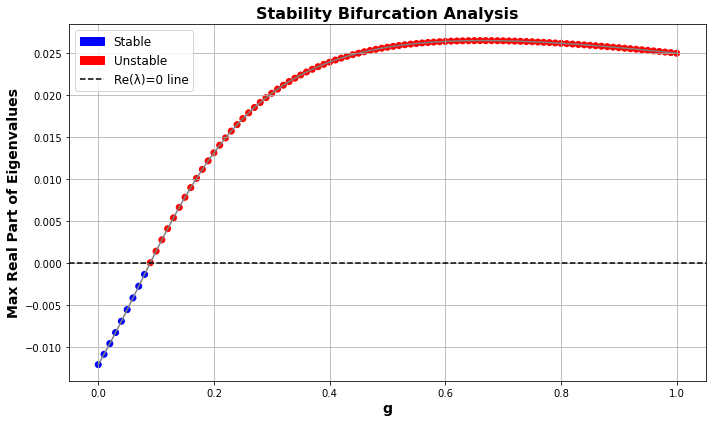

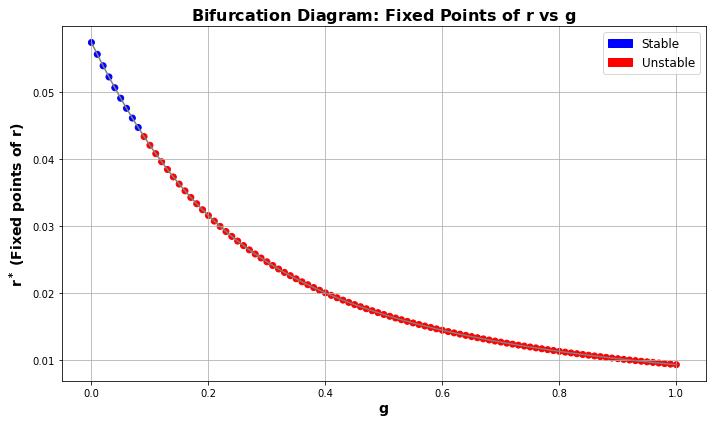

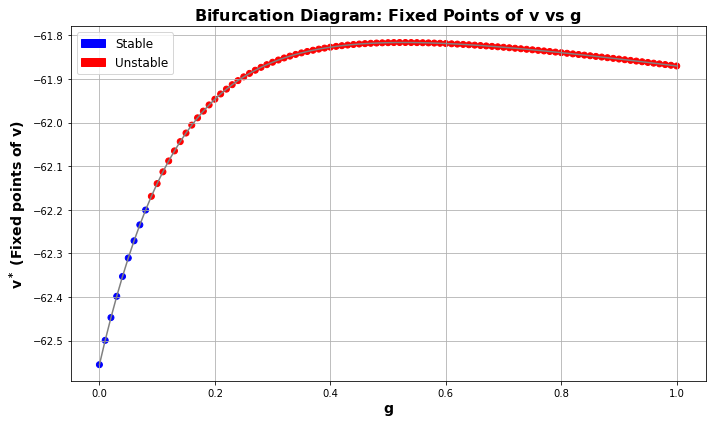

Bifurcation point 1: g ≈ 0.089594


In [48]:

# Parameters (make sure these are defined correctly for your system)
g_values = np.linspace(0, 1, 101)
initial_guess = [0.120, -62]

# Storage arrays
max_real_eigvals = []
r_fixed = []
v_fixed = []
stabilities = []

# Filtered arrays for bifurcation point detection
g_success = []
max_real_eigvals_success = []

# Loop through etaBar values
for g in g_values:
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(g, tauS,), full_output=True)

    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

        # Jacobian matrix at the fixed point
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        # Eigenvalue analysis
        eigvals = np.linalg.eigvals(J)
        max_real_part = np.max(eigvals.real)

        max_real_eigvals.append(max_real_part)
        r_fixed.append(r_fp)
        v_fixed.append(v_fp)
        stabilities.append('Stable' if max_real_part < 0 else 'Unstable')

        # Save only successful results for bifurcation search
        g_success.append(g)
        max_real_eigvals_success.append(max_real_part)

#         print(f"etaBar = {etaBar:.3f}, Max real eigenvalue: {max_real_part:.6f}, "
#               f"Stability: {stabilities[-1]}, Fixed Point r*: {r_fp:.6f}")

        # Update initial guess
        initial_guess = [r_fp, v_fp]

#     else:
#         print(f"fsolve failed for etaBar = {etaBar:.3f}")

# Convert to arrays
g_values = np.array(g_values)
max_real_eigvals = np.array(max_real_eigvals)
r_fixed = np.array(r_fixed)
v_fixed = np.array(v_fixed)
stabilities = np.array(stabilities)

# Define colors for plotting
colors = ['blue' if s == 'Stable' else 'red' for s in stabilities]
stable_patch = mpatches.Patch(color='blue', label='Stable')
unstable_patch = mpatches.Patch(color='red', label='Unstable')

# === Plot max eigenvalue vs etaBar ===
plt.figure(figsize=(10, 6))
plt.plot(g_values[:len(max_real_eigvals)], max_real_eigvals, color='gray')
plt.scatter(g_values[:len(max_real_eigvals)], max_real_eigvals, c=colors)
plt.axhline(0, color='black', linestyle='--', label='Re(λ)=0 line')
plt.xlabel(r'$\mathbf{g}$', fontsize=14, fontweight='bold')
plt.ylabel('Max Real Part of Eigenvalues', fontsize=14, fontweight='bold')
plt.title('Stability Bifurcation Analysis', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch,
                    plt.Line2D([0], [0], color='black', linestyle='--', label="Re(λ)=0 line")], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_g.png')
plt.show()

# === Plot r* vs etaBar ===
plt.figure(figsize=(10, 6))
plt.scatter(g_values[:len(r_fixed)], r_fixed, c=colors)
plt.plot(g_values[:len(r_fixed)], r_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{g}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{r^*}$ (Fixed points of $\mathbf{r}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: Fixed Points of $\mathbf{r}$ vs $\mathbf{g}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_fp_r_g.png')
plt.show()

# === Plot v* vs etaBar ===
plt.figure(figsize=(10, 6))
plt.scatter(g_values[:len(v_fixed)], v_fixed, c=colors)
plt.plot(g_values[:len(v_fixed)], v_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{g}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{v^*}$ (Fixed points of $\mathbf{v}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: Fixed Points of $\mathbf{v}$ vs $\mathbf{g}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_fp_v_g.png')
plt.show()

# === Interpolation & Bifurcation Point Detection ===
eig_interp = interp1d(g_success, max_real_eigvals_success, kind='cubic')
bifurcation_points = []

for i in range(len(etaBar_success) - 1):
    if max_real_eigvals_success[i] * max_real_eigvals_success[i + 1] < 0:
        try:
            bif_point = brentq(eig_interp, g_success[i], g_success[i + 1])
            bifurcation_points.append(bif_point)
        except ValueError:
            continue

# === Print bifurcation points ===
if bifurcation_points:
    for idx, point in enumerate(bifurcation_points):
        print(f"Bifurcation point {idx + 1}: g ≈ {point:.6f}")
else:
    print("No bifurcation point found in the scanned range.")


In [49]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, g, tauS):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.09 , -62]  # initial guesses for r, v
g_values = [0.2]

for g in g_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(g, tauS))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"g = {g:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], g, tauS))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

g = 0.20, Fixed point (r, v, u, s, p): 0.03163042142912749, -61.94645664836843, -16.106078728575792, 0.2616709789945378, 0.2616709789945378
Residuals (should be close to zero):
dr/dt, dv/dt: [-1.5036474669549715e-14, 3.6348701826227625e-13]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


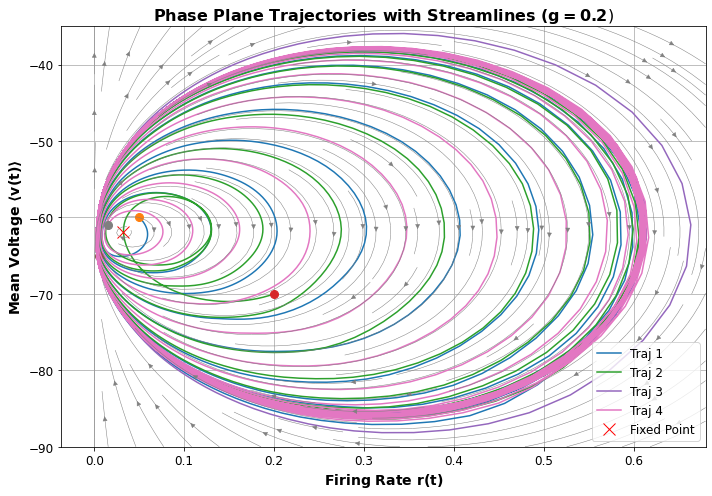

In [50]:
# Define your mean-field equations explicitly
g = 0.2
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]
r_fp = 0.03163042142912749
v_fp = -61.94645664836843
# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.68, 25)
v = np.linspace(-90, -35, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines
plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{({g} = 0.2})}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_g_0.2.png')
plt.show()

In [51]:
# Physical FP r<0
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, g, tauS):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.09 , -62]  # initial guesses for r, v
g_values = [0.02]

for g in g_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(g, tauS))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"g = {g:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], g, tauS))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

g = 0.02, Fixed point (r, v, u, s, p): 0.05397999114035826, -62.44732720702781, -16.236305073827232, 0.4465636716052965, 0.4465636716052965
Residuals (should be close to zero):
dr/dt, dv/dt: [4.796868197792792e-14, 6.551842401947283e-13]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


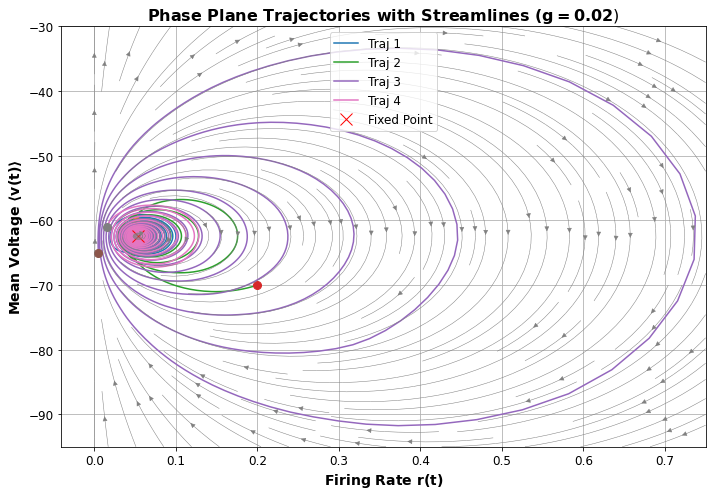

In [52]:
# Define your mean-field equations explicitly
g = 0.02
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]
r_fp = 0.05397999114035826
v_fp = -62.44732720702781

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.75, 25)
v = np.linspace(-95, -30, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines
plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{({g} = 0.02})}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_g_0.02.png')
plt.show()

# $\tau_s$ Bifurcation Analysis

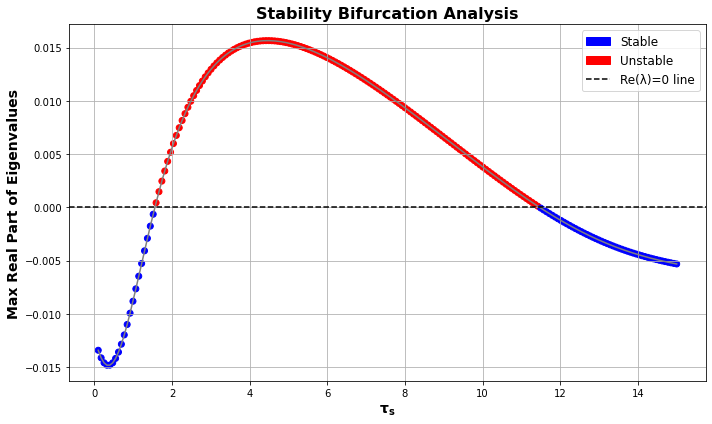

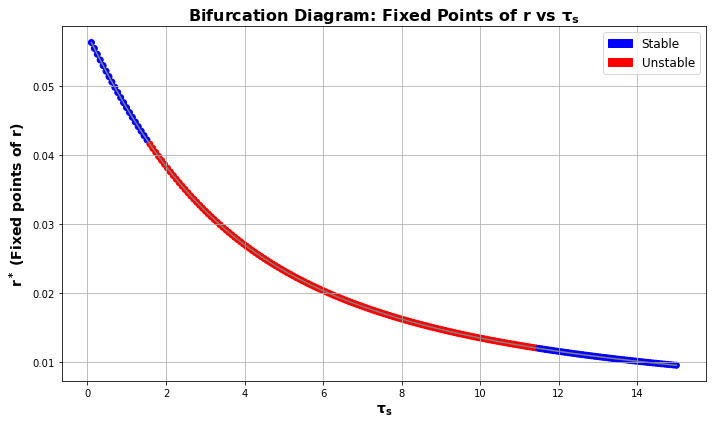

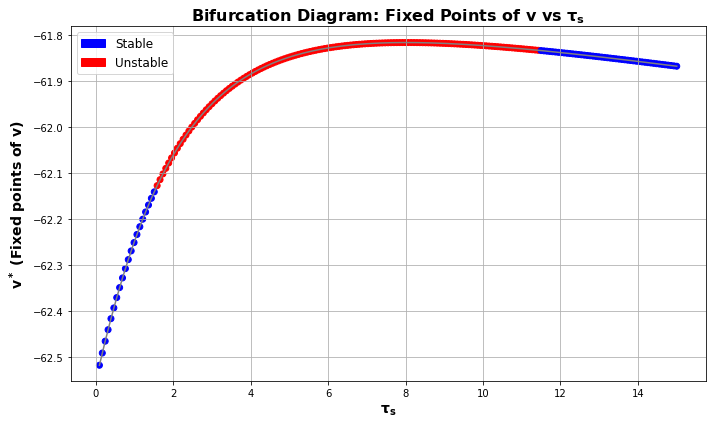

Bifurcation point 1: tauS ≈ 1.559279


In [53]:
g = 0.2
# Parameters (make sure these are defined correctly for your system)
tauS_values = np.linspace(0.1, 15, 201)
initial_guess = [0.120, -62]

# Storage arrays
max_real_eigvals = []
r_fixed = []
v_fixed = []
stabilities = []

# Filtered arrays for bifurcation point detection
tauS_success = []
max_real_eigvals_success = []

# Loop through etaBar values
for tauS in tauS_values:
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(g, tauS,), full_output=True)

    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

        # Jacobian matrix at the fixed point
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        # Eigenvalue analysis
        eigvals = np.linalg.eigvals(J)
        max_real_part = np.max(eigvals.real)

        max_real_eigvals.append(max_real_part)
        r_fixed.append(r_fp)
        v_fixed.append(v_fp)
        stabilities.append('Stable' if max_real_part < 0 else 'Unstable')

        # Save only successful results for bifurcation search
        tauS_success.append(tauS)
        max_real_eigvals_success.append(max_real_part)

#         print(f"etaBar = {etaBar:.3f}, Max real eigenvalue: {max_real_part:.6f}, "
#               f"Stability: {stabilities[-1]}, Fixed Point r*: {r_fp:.6f}")

        # Update initial guess
        initial_guess = [r_fp, v_fp]

#     else:
#         print(f"fsolve failed for etaBar = {etaBar:.3f}")

# Convert to arrays
tauS_values = np.array(tauS_values)
max_real_eigvals = np.array(max_real_eigvals)
r_fixed = np.array(r_fixed)
v_fixed = np.array(v_fixed)
stabilities = np.array(stabilities)

# Define colors for plotting
colors = ['blue' if s == 'Stable' else 'red' for s in stabilities]
stable_patch = mpatches.Patch(color='blue', label='Stable')
unstable_patch = mpatches.Patch(color='red', label='Unstable')

# === Plot max eigenvalue vs etaBar ===
plt.figure(figsize=(10, 6))
plt.plot(tauS_values[:len(max_real_eigvals)], max_real_eigvals, color='gray')
plt.scatter(tauS_values[:len(max_real_eigvals)], max_real_eigvals, c=colors)
plt.axhline(0, color='black', linestyle='--', label='Re(λ)=0 line')
plt.xlabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.ylabel('Max Real Part of Eigenvalues', fontsize=14, fontweight='bold')
plt.title('Stability Bifurcation Analysis', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch,
                    plt.Line2D([0], [0], color='black', linestyle='--', label="Re(λ)=0 line")], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_tauS.png')
plt.show()

# === Plot r* vs etaBar ===
plt.figure(figsize=(10, 6))
plt.scatter(tauS_values[:len(r_fixed)], r_fixed, c=colors)
plt.plot(tauS_values[:len(r_fixed)], r_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{r^*}$ (Fixed points of $\mathbf{r}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: Fixed Points of $\mathbf{r}$ vs $\mathbf{\tau_s}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_fp_r_tauS.png')
plt.show()

# === Plot v* vs etaBar ===
plt.figure(figsize=(10, 6))
plt.scatter(tauS_values[:len(v_fixed)], v_fixed, c=colors)
plt.plot(tauS_values[:len(v_fixed)], v_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{v^*}$ (Fixed points of $\mathbf{v}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: Fixed Points of $\mathbf{v}$ vs $\mathbf{\tau_s}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_fp_v_tauS.png')
plt.show()

# === Interpolation & Bifurcation Point Detection ===
eig_interp = interp1d(tauS_success, max_real_eigvals_success, kind='cubic')
bifurcation_points = []

for i in range(len(etaBar_success) - 1):
    if max_real_eigvals_success[i] * max_real_eigvals_success[i + 1] < 0:
        try:
            bif_point = brentq(eig_interp, tauS_success[i], tauS_success[i + 1])
            bifurcation_points.append(bif_point)
        except ValueError:
            continue

# === Print bifurcation points ===
if bifurcation_points:
    for idx, point in enumerate(bifurcation_points):
        print(f"Bifurcation point {idx + 1}: tauS ≈ {point:.6f}")
else:
    print("No bifurcation point found in the scanned range.")


In [54]:
# Interpolation and bifurcation detection
eig_interp = interp1d(tauS_success, max_real_eigvals_success, kind='cubic')
bifurcation_points = []

# Detect zero crossings (sign changes)
for i in range(len(tauS_success) - 1):
    if max_real_eigvals_success[i] * max_real_eigvals_success[i + 1] < 0:
        try:
            bif_point = brentq(eig_interp, tauS_success[i], tauS_success[i + 1])
            bifurcation_points.append(bif_point)
        except ValueError:
            continue

# Print bifurcation points
if bifurcation_points:
    for idx, point in enumerate(bifurcation_points):
        print(f"Bifurcation point {idx + 1}: tauS ≈ {point:.6f}")
else:
    print("No bifurcation point found in the scanned range.")


Bifurcation point 1: tauS ≈ 1.559279
Bifurcation point 2: tauS ≈ 11.472956


In [56]:
# Physical FP r<0
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, g, tauS):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.09 , -62]  # initial guesses for r, v
tauS_values = [1]

for tauS in tauS_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(g, tauS))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"tauS = {tauS:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], g, tauS))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

tauS = 1.00, Fixed point (r, v, u, s, p): 0.04679519509099147, -62.24998044351808, -16.184994915314704, 0.12721658926764987, 0.12721658926764987
Residuals (should be close to zero):
dr/dt, dv/dt: [-2.7050844203513336e-16, -1.4127587988355117e-14]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
